# Section 1 

Name: Michelle Fong  


## Question 1 - I

In [74]:
from sklearn.base import BaseEstimator
from scipy.spatial import KDTree
from sklearn.model_selection import train_test_split
import numpy as np

class KnnRegressor(BaseEstimator):
    # k: number of neighbours to be considered
    def __init__(self,k): 
        self.k = k
        
    def fit(self, x, y):
        self.y_train_ = y
        self.x_train_kdtree_ = KDTree(x)
        return self

    def predict(self, x):
        # find k-nearest neighbours of x
        _, neighbours = self.x_train_kdtree_.query(x, k=self.k)
        
        # find the cloest k point of each record x_i
        neighbours = neighbours.reshape(len(x), self.k)    

        # store the points
        neighbour_labels = self.y_train_[neighbours]    

        # prediction = mean of the nearest k points
        m = np.mean(neighbour_labels, axis=1)    
        return m.squeeze()

## Question 1 - II

### Diabetes example

#### Loading and Inspecting data

In [75]:
from sklearn.datasets import load_diabetes, fetch_california_housing
diabetes  = load_diabetes()
diabetes

{'data': array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
          0.01990749, -0.01764613],
        [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
         -0.06833155, -0.09220405],
        [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
          0.00286131, -0.02593034],
        ...,
        [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
         -0.04688253,  0.01549073],
        [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
          0.04452873, -0.02593034],
        [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
         -0.00422151,  0.00306441]]),
 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
         69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
         68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
         87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
        259.,  53., 190., 142.,  75., 142., 155., 225.,  59

In [76]:
diabetes.data.shape, diabetes.target.shape, diabetes.feature_names

((442, 10),
 (442,),
 ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'])

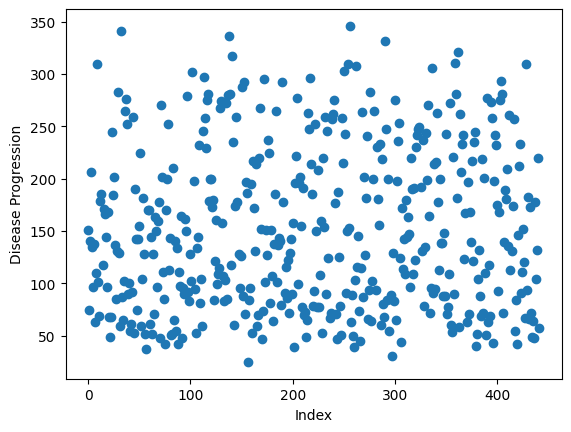

In [77]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(len(diabetes.target)),diabetes.target)
plt.xlabel('Index')
plt.ylabel('Disease Progression')
plt.show()

The dataset contains 442 samples showing the demogrphic and blood serum measurements data. They are used to predict the disease progression one year after baseline which is our target.

#### Splitting data

In [78]:
# split into train(60%) and test (40%) dataset
diabetes_x_train, diabetes_x_test, diabetes_y_train, diabetes_y_test = train_test_split(diabetes.data, diabetes.target, train_size=0.6, random_state=0)

In [79]:
knn = KnnRegressor(k=5)

# fit and predict
knn.fit(diabetes_x_train, diabetes_y_train)

diabetes_yhat_train = knn.predict(diabetes_x_train)
diabetes_yhat_test = knn.predict(diabetes_x_test)

#### MSE of the model

In [80]:
# using mean square of error
def error_rate(y, y_hat):
    mse = np.mean((y - y_hat) ** 2)/2
    return mse

print(f'MSE of training set: {round(error_rate(diabetes_y_train, diabetes_yhat_train),4)},\n'
      f'MSE of test set: {round(error_rate(diabetes_y_test, diabetes_yhat_test),4)}')


MSE of training set: 1215.5689,
MSE of test set: 1911.3741


#### Cross Validating using Bootstrap

In [81]:
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error


class BootstrapSplitter:

    def __init__(self, reps, train_size, random_state=None):
        self.reps = reps
        self.train_size = train_size
        self.RNG = np.random.default_rng(random_state)

    def get_n_splits(self):
        return self.reps

    def split(self, x, y=None, groups=None):
        for _ in range(self.reps):
            train_idx = self.RNG.choice(np.arange(len(x)), round(len(x)*self.train_size),replace = True)
                    # np.arange(len(x))): create a series of len(x) 
                    # from there sample 
            test_idx = np.setdiff1d(np.arange(len(x)), train_idx)
            np.random.shuffle(test_idx)
            yield train_idx, test_idx

bootstrap = BootstrapSplitter(5, 0.6, random_state=0)
cross_validate(knn, diabetes_x_test, diabetes_y_test, cv=bootstrap, 
               return_train_score=True, 
               scoring=make_scorer(mean_squared_error))

{'fit_time': array([2.94208527e-04, 3.61919403e-04, 1.40905380e-04, 1.01804733e-04,
        9.79900360e-05]),
 'score_time': array([0.00123191, 0.00083709, 0.00075698, 0.00054812, 0.00048113]),
 'test_score': array([4474.26595745, 4849.6844898 , 4460.99793814, 4317.0419802 ,
        4627.45      ]),
 'train_score': array([2394.95169811, 2300.77698113, 2480.37056604, 2169.72792453,
        2614.55056604])}

### Housing example

#### Loading and inspecting data

In [82]:
housing = fetch_california_housing()
housing

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

In [83]:
housing.data.shape, housing.target.shape, housing.feature_names, housing.target_names

((20640, 8),
 (20640,),
 ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 ['MedHouseVal'])

This dataset contains 20640 samples of housing in the US. The goal is to predict the meadian house value for Calinfornia districts given the 8 features.

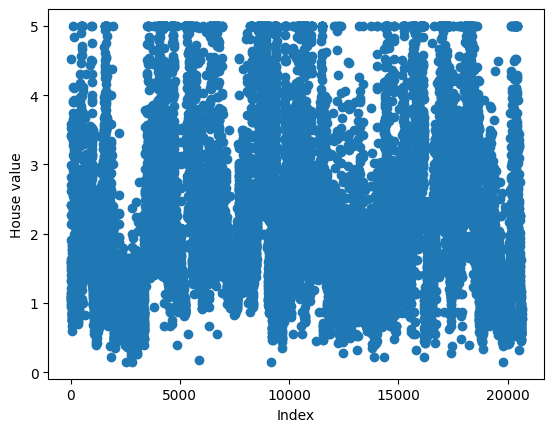

In [84]:
plt.scatter(np.arange(len(housing.target)),housing.target)
plt.xlabel('Index')
plt.ylabel('House value')
plt.show()

#### Splitting Data

In [85]:
# split train(60%) and test(40%) data
housing_x_train, housing_x_test, housing_y_train, housing_y_test = train_test_split(housing.data, housing.target, train_size=0.6, random_state=2)

In [86]:
# fit and predict
knn.fit(housing_x_train, housing_y_train)
housing_yhat_train = knn.predict(housing_x_train)  
housing_yhat_test = knn.predict(housing_x_test)  

#### MSE of the model

In [87]:
print(f'MSE of training set: {round(error_rate(housing_y_train, housing_yhat_train),4)},\n'
      f'MSE of test set: {round(error_rate(housing_y_test, housing_yhat_test),4)}')

MSE of training set: 0.3804,
MSE of test set: 0.5831


#### Cross Validate using Bootstrap

In [88]:
cross_validate(knn, housing_x_test, housing_y_test, cv=bootstrap, return_train_score=True, scoring=make_scorer(mean_squared_error))

{'fit_time': array([0.00538611, 0.00280809, 0.00225019, 0.00208592, 0.00184822]),
 'score_time': array([0.00789499, 0.00617504, 0.00660467, 0.00517511, 0.00480986]),
 'test_score': array([1.42992178, 1.45681151, 1.48296869, 1.48831152, 1.47795042]),
 'train_score': array([0.73467584, 0.71787018, 0.7164842 , 0.6907115 , 0.71614039])}

---

## Question 2

### I

In [146]:
class LFold:
    def __init__(self, n_splits, shuffle = True, random_state=None):
        # constructor - number of splits
        self.n_splits = n_splits   
        self.shuffle = shuffle
        self.random_state = random_state
        self.RNG = np.random.default_rng(self.random_state)
        
    def get_n_splits(self):
        return self.n_splits 
    
    def split(self, x, y=None, groups=None):
        n_samples = len(x)
        # find the size of each fold -- even distribution of the data
        fold_size = n_samples // self.n_splits    

        # indicates position of the data point
        indices = np.arange(n_samples)

        # shuffle the whole dataset
        if self.shuffle:
            self.RNG = np.random.default_rng(self.random_state)
            
            for i in range(self.n_splits):
                self.RNG.shuffle(indices)

                # rest = training data
                train_indices = indices[fold_size:]
                # first fold = test
                test_indices = indices[:fold_size]
                yield train_indices, test_indices

# Test using range(20)
for idx_train, idx_test in LFold(5,random_state=0).split(list(range(20))):
    print('Train:', idx_train, 'Test:', idx_test)


Train: [13 16  3 11 10  8  0 12  7  5 18 17 14  9  1 15] Test: [ 4 19  6  2]
Train: [ 3  6  2 16  1 19  0  8 18 15 10  5  7 17  9  4] Test: [12 14 13 11]
Train: [ 6  1  3 10 18 19  9  7 15 13  2 11 14 17  5 12] Test: [16  8  4  0]
Train: [ 2  8  5  9  0 18  3 13 15  4  6 19 16 12 17 11] Test: [ 1  7 10 14]
Train: [ 4 14 17 19  0 11  5  6 16  9  2 18 10  3  1 13] Test: [15  8 12  7]


### II

In [147]:
class KNNExperiment:
    # constructor: initialise dataset, range of k, number of split for cv
    def __init__(self, dataset, n_splits=5):
        self.dataset = dataset
        self.n_splits = n_splits
        
        self.mean_train_results = []
        self.mean_test_results = []
        self.sd_train_results = []
        self.sd_test_results = []

    # simulating 
    def run(self, max_k, cv):
        x, y = self.dataset.data, self.dataset.target
        # to store result (best number of k & smaller mse)
        best_k = None
        best_test_mse = float('inf')

        # loop through each the ks
        r = cv.get_n_splits()
        test_results = np.zeros(shape=(r, max_k))
        train_results = np.zeros(shape=(r, max_k))
        
        for k in range(1, max_k+1):
            knn_regressor = KnnRegressor(k=k)
            cv_res = cross_validate(knn_regressor, 
                                    x, y, 
                                    cv=cv, 
                                    return_train_score=True, 
                                    scoring=make_scorer(mean_squared_error))
            
            test_results[:, k-1] = cv_res['test_score']
            train_results[:, k-1] = cv_res['train_score']

            # with each k, find mean and sd mse
            mean_train_mse = np.mean(test_results)
            mean_test_mse = np.mean(test_results)
            
            
            std_train_mse = np.std(test_results)
            std_test_mse = np.std(test_results)

            # store result for specific k
            self.mean_train_results.append(mean_train_mse)
            self.mean_test_results.append(mean_test_mse)

            z = (r**0.5)/1.96 
            self.sd_train_results.append(std_train_mse/z)
            self.sd_test_results.append(std_test_mse/z)

            # print(f'When K={k}: \n Mean Test MSE={mean_test_mse}, Std Test MSE={std_test_mse}')

        best_k= np.argmin(test_results.mean(axis=0))
        print(f'When K={best_k}: \n Mean Test MSE={self.mean_test_results[best_k-1]}, Std Test MSE={self.sd_test_results[best_k-1]}')

        # until the optimal k is found
        return best_k,train_results, test_results


    def sanity_check(self):
        print('Length of mean_train_results:',len(self.mean_train_results))
        print('Length of mean_test_results:',len(self.mean_test_results))
        print('Length of sd_train_results:',len(self.sd_train_results))
        print('Length of sd_test_results:',len(self.sd_test_results))

    
    def eva_plot(self, max_k,train_results, test_results):
        ks = np.arange(1, max_k+1)
        _, axs = plt.subplots(1, 2, figsize=(8,4), tight_layout=True, sharey=True)
        z = (5**0.5)/1.96 
            # normalising the error rate due to difference size of reps
        
        axs[0].errorbar(ks, train_results.mean(axis=0), yerr=train_results.std(axis=0)/z, marker='o', label='train')
        axs[0].errorbar(ks, test_results.mean(axis=0), yerr=test_results.std(axis=0)/z, marker='o', label='test')
        axs[0].axvline(best_k,color='blue',ls='--',label='Best K')
        axs[0].legend()
        axs[0].set_xlabel('$k$')
        axs[0].set_ylabel('error rate')
        
        axs[1].errorbar(1/ks, train_results.mean(axis=0), yerr=train_results.std(axis=0)/z, marker='o', label='train')
        axs[1].errorbar(1/ks, test_results.mean(axis=0), yerr=test_results.std(axis=0)/z, marker='o', label='test')
        axs[1].axvline(1/best_k,color='blue',ls='--',label='1/Best K')
        axs[1].legend()
        axs[1].set_xscale('log')
        axs[1].set_xlabel('$1/k$')
        plt.show()

### Diabetes Example - 50 k

When K=15: 
 Mean Test MSE=1128.387850279683, Std Test MSE=1576.037061834406
Length of mean_train_results: 50
Length of mean_test_results: 50
Length of sd_train_results: 50
Length of sd_test_results: 50


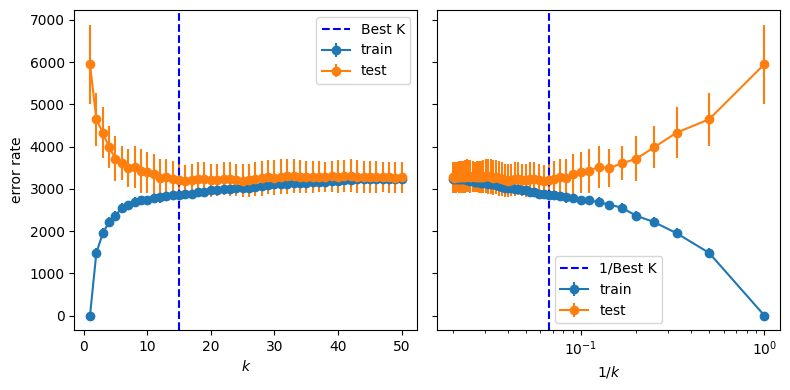

Best K for Diabetes: 15


In [149]:
knn_experiment_diabetes = KNNExperiment(diabetes)
best_k,train_results, test_results = knn_experiment_diabetes.run(max_k=50,
                                                                 cv = LFold(n_splits=5, random_state = 0))

# sanity check -- expected len = 50 for each k
knn_experiment_diabetes.sanity_check()

knn_experiment_diabetes.eva_plot(50,train_results, test_results)

print(f'Best K for Diabetes: {best_k}')

Thus the optimal number of k for **diabetes** datasetd is **k=15** where the Mean Test MSE=1128.3879, Std Test MSE=1576.0371


### Housing Example - 50 k

When K=7: 
 Mean Test MSE=0.16903357357463705, Std Test MSE=0.37124449206542043
Best K for California Housing: 7
Length of mean_train_results: 50
Length of mean_test_results: 50
Length of sd_train_results: 50
Length of sd_test_results: 50


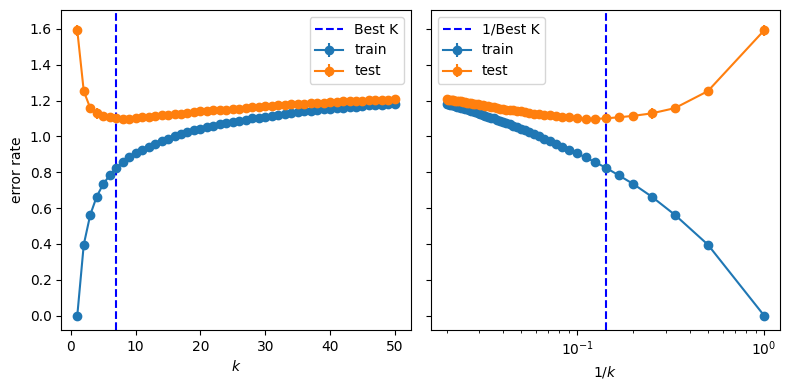

In [150]:
knn_experiment_housing = KNNExperiment(housing)
best_k,train_results, test_results  = knn_experiment_housing.run(max_k=50,cv = LFold(n_splits=5, random_state = 1))
print(f'Best K for California Housing: {best_k}')

knn_experiment_housing.sanity_check()
knn_experiment_housing.eva_plot(50,train_results, test_results)

For Califonia Housing example, **best k** is **7** with Mean Test MSE=0.1690, Std Test MSE=0.1690

### Conclusion:

Both dataset have a similar result plot against k: when k = 1, the error of train dataset is the lowest but the error in test dataset is highest. Since our focus is generalization error which is estimated by test error, best_k is decided based on the minimum of test error.  

From lecture slide, we conclude that test error is much larger than train error when overfitting. Hence **when k is small, the model is overfitting**, this aligns with the plots above for both dataset. This means the model is most complex when k = 1.   
 
When k is around 50, train and test error are similar, this is still within the optimal solution of k. If we keep increase k, we might observe train and test error increase again. In which case, we will observe underfit.  

Intuitively, k=1 overfits because the model is affectly by small local change around point too easily. To capture such abrupt change, the model is more complex and too flexible. More specifically, the prediction is made based on the nearest point.

### Effect of L

We can examine the effect of L of the CV procedure:

#### Diabetes Example - diff L split

In [151]:
l_size = [2, 5, 10, 15, 20]
best_ks = []
train_results_lsizes = []
test_results_lsizes = []

for l in l_size:
    print('L size: ', l)
    best_k,train_res, test_res = knn_experiment_diabetes.run(max_k=50,
                                                             cv = LFold(n_splits=l, 
                                                                        random_state = 0))
    best_ks.append(best_k)
    train_results_lsizes.append(train_res)
    test_results_lsizes.append(test_res)

L size:  2
When K=12: 
 Mean Test MSE=933.7830272633771, Std Test MSE=1515.551015533547
L size:  5
When K=15: 
 Mean Test MSE=1128.387850279683, Std Test MSE=1576.037061834406
L size:  10
When K=16: 
 Mean Test MSE=1192.227468532524, Std Test MSE=1590.432138017771
L size:  15
When K=17: 
 Mean Test MSE=1256.5041225117627, Std Test MSE=1603.17572917129
L size:  20
When K=26: 
 Mean Test MSE=1835.5864142552516, Std Test MSE=1629.1159578981012


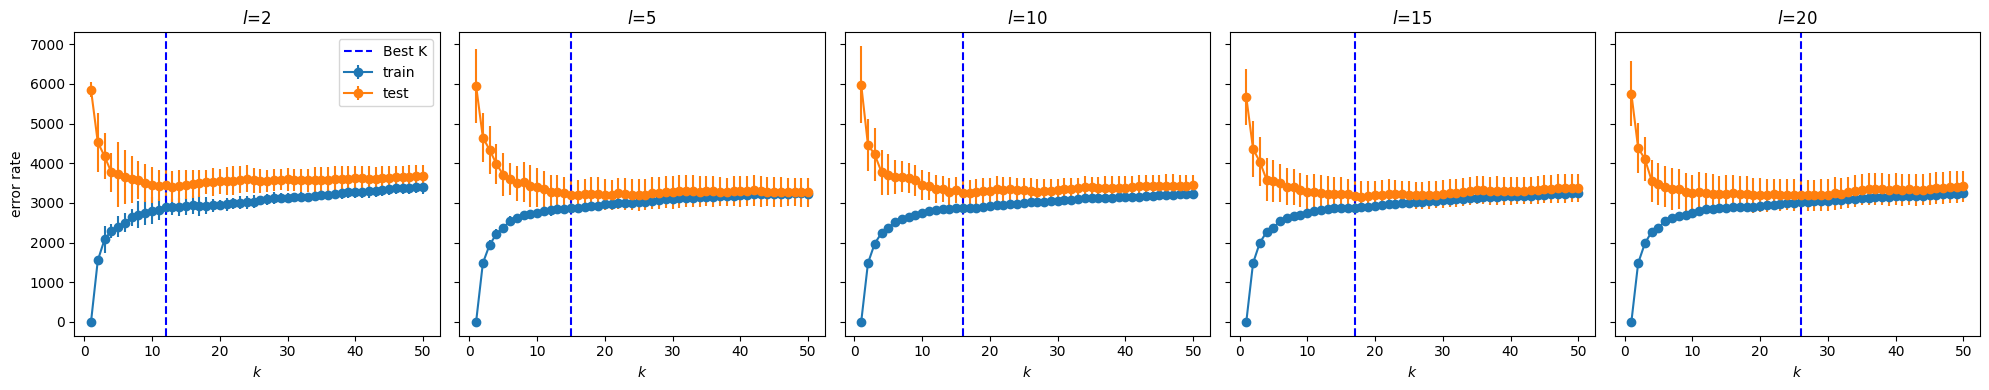

In [152]:
max_k = 50
ks = np.arange(1, max_k+1)
_, axs = plt.subplots(1, len(l_size), figsize=(4*len(l_size),4), tight_layout=True, sharey=True)
for i, l in enumerate(l_size):
    z = l**0.5/1.96
    axs[i].set_title(f'$l$={l}')
    axs[i].errorbar(ks, train_results_lsizes[i].mean(axis=0), yerr=train_results_lsizes[i].std(axis=0)/z, marker='o', label='train')
    axs[i].errorbar(ks, test_results_lsizes[i].mean(axis=0), yerr=test_results_lsizes[i].std(axis=0)/z, marker='o', label='test')
    axs[i].axvline(best_ks[i],color='blue',ls='--',label='Best K')
    axs[i].set_xlabel('$k$')
    
axs[0].legend()    
axs[0].set_ylabel('error rate')
plt.show()

#### Housing Example - diff L split

In [153]:
l_size = [2, 5, 10, 15, 20]
best_ks = []
train_results_lsizes = []
test_results_lsizes = []

for l in l_size:
    print('L size: ', l)
    best_k,train_res, test_res = knn_experiment_housing.run(max_k=50,cv = LFold(n_splits=l, random_state = 1))
    best_ks.append(best_k)
    train_results_lsizes.append(train_res)
    test_results_lsizes.append(test_res)

L size:  2
When K=7: 
 Mean Test MSE=0.16903357357463705, Std Test MSE=0.37124449206542043
L size:  5
When K=7: 
 Mean Test MSE=0.16903357357463705, Std Test MSE=0.37124449206542043
L size:  10
When K=7: 
 Mean Test MSE=0.16903357357463705, Std Test MSE=0.37124449206542043
L size:  15
When K=6: 
 Mean Test MSE=0.14701769777860638, Std Test MSE=0.3529057651915802
L size:  20
When K=6: 
 Mean Test MSE=0.14701769777860638, Std Test MSE=0.3529057651915802


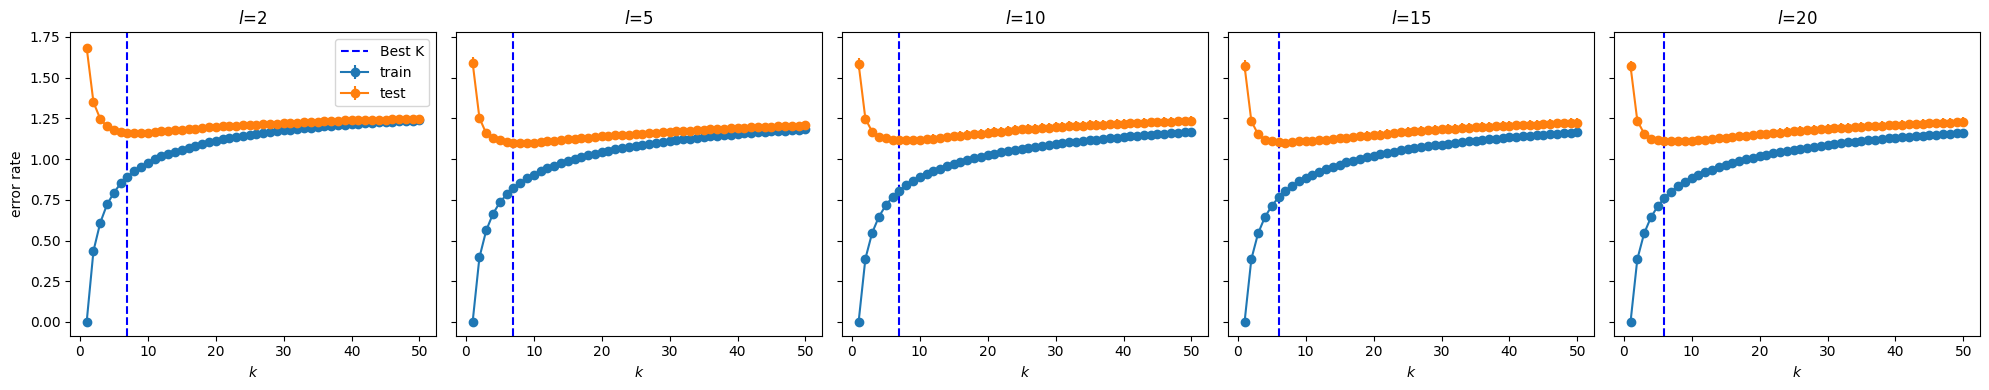

In [154]:
max_k = 50
ks = np.arange(1, max_k+1)
_, axs = plt.subplots(1, len(l_size), figsize=(4*len(l_size),4), tight_layout=True, sharey=True)
for i, l in enumerate(l_size):
    z = l**0.5/1.96
    
    axs[i].set_title(f'$l$={l}')
    axs[i].errorbar(ks, train_results_lsizes[i].mean(axis=0), yerr=train_results_lsizes[i].std(axis=0)/z, marker='o', label='train')
    axs[i].errorbar(ks, test_results_lsizes[i].mean(axis=0), yerr=test_results_lsizes[i].std(axis=0)/z, marker='o', label='test')
    axs[i].axvline(best_ks[i],color='blue',ls='--',label='Best K')
    axs[i].set_xlabel('$k$')
axs[0].legend()    
axs[0].set_ylabel('error rate')
plt.show()

The result varies from validate sets.  

For Diabetes dataset, MSE is minimised when L splits = 2 and k = 15, both the mean and standard deviation of MSE is at the lowest. When L split increase, the average MSE and its standard deviation increase.

For Housing dataset, MSE is at its optimal when L splits = 2, 10 and 15, and k = 7. This case setting n_splits = 15 would be preferred to keep the model simple since it take average of the nearest 15 point which has more data point for referrence.

From this 2 dataset, it is concluded that the effect of CV size seems to be in qudratic term with the MSE or the goodness of the fit in general.   

Intuitively, if the split is too large, it means the size of each fold decrease which means for each fold, the central point is more easily affected by the surrounding points. This is similar to saying the model is too flexible and hence the MSE would be great.  

When the split is too small, there is not enough data for the model to learn which is the underfitting case and results in a high MSE.

## Question 3

#### I - list of 20 k with CV

In [155]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from scipy.spatial import KDTree

class KnnRegressorCV(BaseEstimator):
    def __init__(self, ks=list(range(1, 21)), cv=LFold(5),random_state=None):
        self.ks = ks
        self.cv = cv
        self.random_state = random_state
        # a dict to store result of each k with cv
        self.k_scores_ = {}
    
    
    def fit(self, x, y):
        self.y_train_ = y
        self.x_train_ = x
        self.x_train_kdtree_ = KDTree(self.x_train_)
        
        for k in self.ks:
            knn_regressor = KnnRegressor(k=k)
            cv_res = cross_validate(knn_regressor, 
                                    self.x_train_, self.y_train_, 
                                    cv=self.cv, return_train_score=True, 
                                    scoring=make_scorer(mean_squared_error))
            
            # dict of mean MSE of each k (average of each cv)
            self.k_scores_[k] = np.mean(cv_res['test_score'])

        # find global min of k_scores and return its key 
        self.k_ = np.argmin(list(self.k_scores_.values()))
        return self

    
    def predict(self, x):
        # find k-nearest neighbours of x with k = self.k_
        _, neighbours = self.x_train_kdtree_.query(x, k=self.k_)
        
        # find the cloest k point of each record x_i
        neighbours = neighbours.reshape(len(x), self.k_)

        # store the points
        neighbour_labels = self.y_train_[neighbours]

        # prediction = mean of the nearest k points
        m = np.mean(neighbour_labels, axis=1)
        return m.squeeze()

#### Testing - list of 20 k with CV

In [164]:
knn_cv_diabetes = KnnRegressorCV(random_state=0,cv=LFold(n_splits=5, random_state = 0))

# fit the model
knn_cv_diabetes.fit(diabetes_x_train, diabetes_y_train)

# prediction 
predictions_diabetes = knn_cv_diabetes.predict(diabetes_x_test)

# mse
mse_diabetes = error_rate(diabetes_y_test, predictions_diabetes)

best_k = knn_cv_diabetes.k_

print('Best k: ', best_k)
print('Mean Squared Error (Diabetes):', round(mse_diabetes,4))

Best k:  11
Mean Squared Error (Diabetes): 1574.7698


In [166]:
knn_cv_housing = KnnRegressorCV(random_state=1,cv=LFold(n_splits=5, random_state = 1))

# fit the model
knn_cv_housing.fit(housing_x_train, housing_y_train)

# prediction 
predictions_housing = knn_cv_housing.predict(housing_x_test)

# mse
mse_housing = error_rate(housing_y_test, predictions_housing)

best_k = knn_cv_housing.k_
print('Best k: ', best_k)
print('Mean Squared Error (Housing):', round(mse_housing,4))


Best k:  8
Mean Squared Error (Housing): 0.5749


#### II - 20 k with inner CV  (on KnnRegressor) and outer CV (on spliting data)

In [177]:
# outer cross validation with LFold
outer_cv = LFold(n_splits=5, shuffle=True, random_state=0)

best_ks_diabetes = []
mse_diabetes_list = []

for train_idx, test_idx in outer_cv.split(diabetes.data):
    # split into training & testing ds with outerCV
    diabetes_x_train, diabetes_x_test = diabetes.data[train_idx], diabetes.data[test_idx]
    diabetes_y_train, diabetes_y_test = diabetes.target[train_idx], diabetes.target[test_idx]
    
    # KnnRegressorCV - for k in (1,20)
    knn_cv_diabetes = KnnRegressorCV(random_state=0, 
                                     ks=list(range(1, 21)), 
                                     cv=LFold(5, random_state=0))
    
    # fit with training dataset generated above
    knn_cv_diabetes.fit(diabetes_x_train, diabetes_y_train)
    
    # store the argmin k for the specific training ds & the mse(y_test, prediciton)
    best_ks_diabetes.append(knn_cv_diabetes.k_)
    mse_diabetes_list.append(error_rate(diabetes_y_test, knn_cv_diabetes.predict(diabetes_x_test)))
    
# avg of 5-split - best_k & mse
mean_best_ks_diabetes = np.mean(best_ks_diabetes)
mean_mse_diabetes = np.mean(mse_diabetes_list)

r = outer_cv.get_n_splits()
z = (r**0.5)/1.96 
ste_mse_diabetes = np.std(mse_diabetes_list)/z

print('Mean chosen k-value (Diabetes):', mean_best_ks_diabetes)
print('Mean of MSE:', round(mean_mse_diabetes,4), '\n SD of MSE: ', round(ste_mse_diabetes,4))

Mean chosen k-value (Diabetes): 15.4
Mean of MSE: 1661.9451 
 SD of MSE:  247.6427


In [180]:
best_ks_diabetes

[16, 10, 13, 19, 19]

In [179]:
best_ks_housing = []
mse_housing_list = []
for train_idx, test_idx in outer_cv.split(housing.data):
    housing_x_train, housing_x_test = housing.data[train_idx], housing.data[test_idx]
    housing_y_train, housing_y_test = housing.target[train_idx], housing.target[test_idx]
    
    knn_cv_housing = KnnRegressorCV(random_state=1, 
                                    ks=list(range(1, 21)), 
                                    cv=LFold(5, random_state=1))
    knn_cv_housing.fit(housing_x_train, housing_y_train)
    
    best_ks_housing.append(knn_cv_housing.k_)
    mse_housing_list.append(mean_squared_error(housing_y_test, knn_cv_housing.predict(housing_x_test)))

mean_best_ks_housing = np.mean(best_ks_housing)
mean_mse_housing = np.mean(mse_housing_list)

r = outer_cv.get_n_splits()
z = (r**0.5)/1.96 
ste_mse_diabetes = np.std(mse_housing_list)/z

print('Mean chosen k-value (Housing):', mean_best_ks_housing)
print('Mean of MSE:', round(mean_mse_housing,4), '\n SD of MSE: ', round(ste_mse_diabetes,4))


Mean chosen k-value (Housing): 7.4
Mean of MSE: 1.1199 
 SD of MSE:  0.0214


In [181]:
best_ks_housing

[7, 7, 8, 7, 8]

<ins> Outer CV (single cv)</ins>:  
Only cross validate on train-test split into 5 folds and reserve 1 fold as validating fold.


<ins> Nested CV</ins>:  
outer: as above  
inner: testing 1-20 nearest k to find the lowest MSE



For Diabetes dataset,  
Nested CV:  k = 15.4, mean MSE = 1661.9451 , std MSE = 247.6427
Outer CV: k =14, mean MSE = 1128.3879, std MSE = 1576.0371


For Housing dataset:  
Nested CV: k = 7.4, mean MSE = 1.1199 , std MSE = 0.0214
Outer CV: k =7, mean MSE = 0.1690, std MSE = 0.1690

The list of best ks generated for both dataset above are fairly close to the outer cv chosen k. In both case, mean MSE increaes compared to only implementing outer cv but the standard error of the MSE using nested cv are much less.   

This can be explained by the bias-variance trade off. Using nested cv ensure there is no overfitting as the outer cv splitted the training set into multiple fold for training. The average of the training result is used to avoid the model trained specific to only 1 dataset.     

mean MSE is higher because each fold and the defined training set used in training is different. The outer cv control the oiginial dataset and the inner cv control the the fold used. Therefore the training set used in builiding model may differs a lot from each other. With more variety of information, the dispersion of model performance will be narrowed.   

The increase in mean MSE suggests the model generated using nested cv has slightly worse performance than model using only outer cv. One possible explaination is: when only outer cv is used, the entire training dataset is used to develop a model. The size of training dataset using nested cv is smaller because there is 1 fold kept out of the bag for inner validation.ß  This explains why the mean MSE increase but the SD reduced.

The inner cross validation (ie determinating the best value of k for KNN regressor) is affected by multiple factors:

1) amount of data: if more data is available in general, then we could know more information about the population and hence the model would perform better.
2) number of fold: given the same amount of data, if the number of fold increase, the size of each fold would have to decrease. This mean the information leanred from the validate set is limited and so the variance would be higher and hence the model would perform worse. This is also shown in Q2 - effect of L.
3) model complexity: when the model is too flexible, it will fit the noise as well and so overfit to a specific dataset. Otherwise, the model underfit and fail to capture the underlying relationship. MSE will be high in both case and performance would be bad.

There are other possible factor affecting the result of the model such as weather the cv shuffle the dataset and the chosen loss function.